# Machine Learning Practical: Coursework 2

**Due date: 16:00 Thursday 24th November 2016**


## Part 1: Combining L1 and L2 penalities

The following the L1 and L2 penalities provided in Lab 5

In [1]:
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * np.sign(parameter)
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)


The definition of regularisation method combining L1 and L2

In [2]:
class L1_L2_Penalty(object):
    """L1 and L2 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their norm.
    """
    
    def __init__(self, coeff_L1, coeff_L2):
        """Create a new L1_L2 penalty object.
        
        Args:
            coeff_L1: Positive constant to scale L1 penalty term by.
            coeff_L2: Positive constant to scale L2 penalty term by.

        """
        assert coeff_L1 > 0. and coeff_L2 > 0, 'Penalty coefficient must be positive.'
        self.coeff_L1 = coeff_L1
        self.coeff_L2 = coeff_L2
        
    def __call__(self, parameter):
        """Calculate L1_L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coeff_L1 * abs(parameter).sum() + 0.5 * self.coeff_L2 * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coeff_L1 * np.sign(parameter) + self.coeff_L2 * parameter
    
    def __repr__(self):
        return 'L1Penalty({0}), L2Penalty({1})'.format(self.coeff_L1, self.coeff_L2)

The implementaion of regularisation method combining L1 and L2

In [3]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.layers import ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(0.5, rng)
biases_init = ConstantInit(0.)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [4]:
#Adjustable parameters
num_epochs = 100

weights_penalties = [
#     None,
    L1_L2_Penalty(1e-7,1e-6),
    L1_L2_Penalty(1e-6,1e-5),
    L1_L2_Penalty(1e-5,1e-4),
    L1_L2_Penalty(1e-4,1e-3),
    L1_L2_Penalty(1e-3,1e-2),
#     L1Penalty(1e-5),
#     L2Penalty(1e-4)
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in  weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    
    print('Regularisation: {0}'.format(weights_penalty))
    
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty=weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty=weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty=weights_penalty)
    ])
    
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: L1Penalty(1e-07), L2Penalty(1e-06)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.47e-04
Epoch 5: 1.79s to complete
  error(train)=6.33e-02, acc(train)=9.82e-01, error(valid)=9.60e-02, acc(valid)=9.72e-01, params_penalty=4.47e-04
Epoch 10: 1.77s to complete
  error(train)=2.49e-02, acc(train)=9.93e-01, error(valid)=8.53e-02, acc(valid)=9.77e-01, params_penalty=5.34e-04
Epoch 15: 1.78s to complete
  error(train)=1.17e-02, acc(train)=9.97e-01, error(valid)=8.87e-02, acc(valid)=9.77e-01, params_penalty=5.94e-04
Epoch 20: 1.76s to complete
  error(train)=3.43e-03, acc(train)=1.00e+00, error(valid)=9.55e-02, acc(valid)=9.78e-01, params_penalty=6.29e-04
Epoch 25: 1.83s to complete
  error(train)=1.51e-03, acc(train)=1.00e+00, error(valid)=9.74e-02, acc(valid)=9.79e-01, params_penalty=6.47e-04
Epoch 30: 1.75s to complete
  error(train)=9.52e-04, acc(train)=1.00e+00, error(valid)=1.03e-01, acc(valid)=9.79e-01, params_penalty=6.58e-04
Epoch 35: 1.82s to complet

Regularisation: L1Penalty(1e-06), L2Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.47e-03
Epoch 5: 1.71s to complete
  error(train)=6.31e-02, acc(train)=9.82e-01, error(valid)=9.41e-02, acc(valid)=9.73e-01, params_penalty=4.41e-03
Epoch 10: 1.86s to complete
  error(train)=2.46e-02, acc(train)=9.93e-01, error(valid)=8.25e-02, acc(valid)=9.77e-01, params_penalty=5.22e-03
Epoch 15: 1.77s to complete
  error(train)=1.21e-02, acc(train)=9.97e-01, error(valid)=8.75e-02, acc(valid)=9.78e-01, params_penalty=5.76e-03
Epoch 20: 1.72s to complete
  error(train)=4.07e-03, acc(train)=1.00e+00, error(valid)=9.49e-02, acc(valid)=9.78e-01, params_penalty=6.04e-03
Epoch 25: 1.74s to complete
  error(train)=1.73e-03, acc(train)=1.00e+00, error(valid)=9.23e-02, acc(valid)=9.80e-01, params_penalty=6.16e-03
Epoch 30: 1.72s to complete
  error(train)=1.15e-03, acc(train)=1.00e+00, error(valid)=9.62e-02, acc(valid)=9.79e-01, params_penalty=6.20e-03
Epoch 35: 1.78s to complet

Regularisation: L1Penalty(1e-05), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.47e-02
Epoch 5: 1.70s to complete
  error(train)=6.75e-02, acc(train)=9.81e-01, error(valid)=9.62e-02, acc(valid)=9.72e-01, params_penalty=3.89e-02
Epoch 10: 1.70s to complete
  error(train)=2.94e-02, acc(train)=9.92e-01, error(valid)=8.08e-02, acc(valid)=9.78e-01, params_penalty=4.21e-02
Epoch 15: 1.69s to complete
  error(train)=1.63e-02, acc(train)=9.96e-01, error(valid)=7.98e-02, acc(valid)=9.79e-01, params_penalty=4.32e-02
Epoch 20: 1.73s to complete
  error(train)=9.76e-03, acc(train)=9.98e-01, error(valid)=8.01e-02, acc(valid)=9.79e-01, params_penalty=4.28e-02
Epoch 25: 1.71s to complete
  error(train)=8.38e-03, acc(train)=9.99e-01, error(valid)=8.26e-02, acc(valid)=9.79e-01, params_penalty=4.15e-02
Epoch 30: 1.71s to complete
  error(train)=1.08e-02, acc(train)=9.98e-01, error(valid)=8.60e-02, acc(valid)=9.78e-01, params_penalty=4.00e-02
Epoch 35: 1.70s to complet

Regularisation: L1Penalty(0.0001), L2Penalty(0.001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.47e-01
Epoch 5: 1.66s to complete
  error(train)=1.10e-01, acc(train)=9.70e-01, error(valid)=1.17e-01, acc(valid)=9.67e-01, params_penalty=1.73e-01
Epoch 10: 1.68s to complete
  error(train)=8.38e-02, acc(train)=9.77e-01, error(valid)=9.54e-02, acc(valid)=9.73e-01, params_penalty=1.66e-01
Epoch 15: 1.69s to complete
  error(train)=8.66e-02, acc(train)=9.75e-01, error(valid)=1.02e-01, acc(valid)=9.70e-01, params_penalty=1.62e-01
Epoch 20: 1.79s to complete
  error(train)=7.59e-02, acc(train)=9.79e-01, error(valid)=9.59e-02, acc(valid)=9.71e-01, params_penalty=1.59e-01
Epoch 25: 1.84s to complete
  error(train)=7.67e-02, acc(train)=9.79e-01, error(valid)=9.68e-02, acc(valid)=9.73e-01, params_penalty=1.56e-01
Epoch 30: 1.71s to complete
  error(train)=7.19e-02, acc(train)=9.80e-01, error(valid)=9.21e-02, acc(valid)=9.73e-01, params_penalty=1.53e-01
Epoch 35: 1.71s to complet

Regularisation: L1Penalty(0.001), L2Penalty(0.01)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.47e+00
Epoch 5: 1.74s to complete
  error(train)=3.65e-01, acc(train)=9.07e-01, error(valid)=3.41e-01, acc(valid)=9.16e-01, params_penalty=4.39e-01
Epoch 10: 1.73s to complete
  error(train)=3.43e-01, acc(train)=9.09e-01, error(valid)=3.17e-01, acc(valid)=9.15e-01, params_penalty=4.29e-01
Epoch 15: 1.76s to complete
  error(train)=3.50e-01, acc(train)=9.07e-01, error(valid)=3.23e-01, acc(valid)=9.14e-01, params_penalty=4.28e-01
Epoch 20: 1.74s to complete
  error(train)=3.47e-01, acc(train)=9.05e-01, error(valid)=3.20e-01, acc(valid)=9.14e-01, params_penalty=4.24e-01
Epoch 25: 1.74s to complete
  error(train)=3.52e-01, acc(train)=9.02e-01, error(valid)=3.26e-01, acc(valid)=9.11e-01, params_penalty=4.16e-01
Epoch 30: 1.74s to complete
  error(train)=3.38e-01, acc(train)=9.12e-01, error(valid)=3.14e-01, acc(valid)=9.22e-01, params_penalty=4.15e-01
Epoch 35: 1.73s to complet

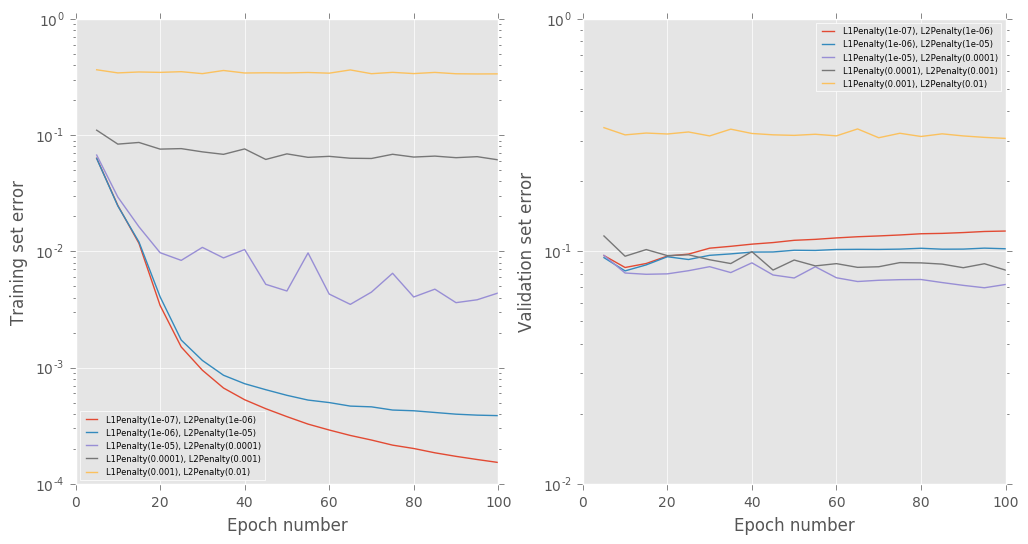

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
final_params_penalty= []
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    
    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])
    final_params_penalty.append(stats[-1,keys['params_penalty']])
    
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc='best',prop={'size':6})
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best',prop={'size':6})
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('L1_L2.pdf')

In [6]:
weights_penalties = [
#     None,
    L1_L2_Penalty(1e-7,1e-6),
    L1_L2_Penalty(1e-6,1e-5),
    L1_L2_Penalty(1e-5,1e-4),
    L1_L2_Penalty(1e-4,1e-3),
    L1_L2_Penalty(1e-3,1e-2),
#     L1Penalty(1e-5),
#     L2Penalty(1e-4)
]
j = 0
print('| weight_penalty                   | error(train) | error(valid)| acc(train)| acc(valid) |params_penalty|')
print('|----------------------------------|--------------|-------------|-----------|------------|-----------|')
for weight_penalty in weights_penalties :
    print('| {0} | {1:.2e}   | {2:.2e}         |  {3:.2e}       | {4:.2e}     | {5:.2e}'
          .format(weight_penalty, 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j], final_params_penalty[j]))
    j += 1

| weight_penalty                   | error(train) | error(valid)| acc(train)| acc(valid) |params_penalty|
|----------------------------------|--------------|-------------|-----------|------------|-----------|
| L1Penalty(1e-07), L2Penalty(1e-06) | 1.53e-04   | 1.22e-01         |  1.00e+00       | 9.79e-01     | 7.05e-04
| L1Penalty(1e-06), L2Penalty(1e-05) | 3.87e-04   | 1.03e-01         |  1.00e+00       | 9.80e-01     | 5.81e-03
| L1Penalty(1e-05), L2Penalty(0.0001) | 4.39e-03   | 7.21e-02         |  1.00e+00       | 9.80e-01     | 3.38e-02
| L1Penalty(0.0001), L2Penalty(0.001) | 6.13e-02   | 8.31e-02         |  9.83e-01       | 9.76e-01     | 1.39e-01
| L1Penalty(0.001), L2Penalty(0.01) | 3.37e-01   | 3.06e-01         |  9.09e-01       | 9.21e-01     | 4.13e-01


The implementation of L1, L2 regularisation and the baseline without regularisation

In [7]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.layers import ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100



weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [8]:
weights_penalties = [
    None,
    L1Penalty(1e-5),
    L1Penalty(1e-3),
    L2Penalty(1e-4),
    L2Penalty(1e-2)
]
run_info_2 = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info_2[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=0.00e+00
Epoch 5: 1.01s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.04s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 1.05s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 1.09s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 1.09s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.08s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 1.11s to complet

Regularisation: L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.10e-02
Epoch 5: 1.72s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 1.66s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 1.61s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 1.57s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 1.58s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 1.58s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 1.58s to complet

Regularisation: L1Penalty(0.001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.10e+00
Epoch 5: 1.74s to complete
  error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 1.63s to complete
  error(train)=2.21e-01, acc(train)=9.35e-01, error(valid)=2.14e-01, acc(valid)=9.37e-01, params_penalty=2.76e-01
Epoch 15: 1.63s to complete
  error(train)=2.26e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.37e-01, params_penalty=2.60e-01
Epoch 20: 1.63s to complete
  error(train)=2.83e-01, acc(train)=9.13e-01, error(valid)=2.65e-01, acc(valid)=9.19e-01, params_penalty=2.64e-01
Epoch 25: 1.68s to complete
  error(train)=2.27e-01, acc(train)=9.32e-01, error(valid)=2.24e-01, acc(valid)=9.31e-01, params_penalty=2.57e-01
Epoch 30: 1.67s to complete
  error(train)=2.23e-01, acc(train)=9.34e-01, error(valid)=2.13e-01, acc(valid)=9.38e-01, params_penalty=2.55e-01
Epoch 35: 1.74s to complet

Regularisation: L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=3.69e-03
Epoch 5: 1.25s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 1.43s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 1.42s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 1.17s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 1.15s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 1.26s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 1.21s to complet

Regularisation: L2Penalty(0.01)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=3.69e-01
Epoch 5: 1.19s to complete
  error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01, params_penalty=2.90e-01
Epoch 10: 1.16s to complete
  error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01, params_penalty=2.95e-01
Epoch 15: 1.15s to complete
  error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01, params_penalty=2.96e-01
Epoch 20: 1.16s to complete
  error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01, params_penalty=2.98e-01
Epoch 25: 1.29s to complete
  error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=2.99e-01
Epoch 30: 1.22s to complete
  error(train)=2.03e-01, acc(train)=9.50e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01, params_penalty=2.99e-01
Epoch 35: 1.24s to complet

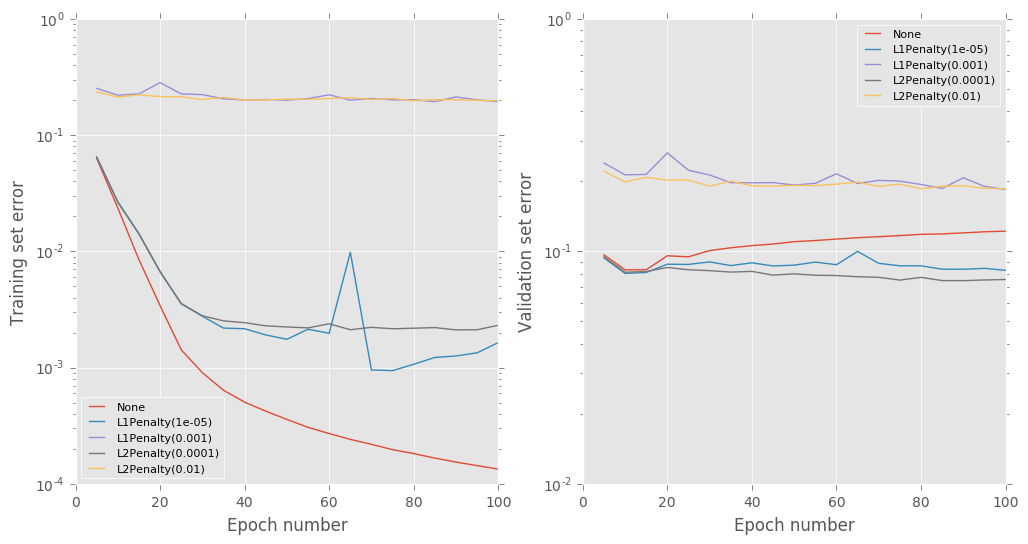

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info_2.items():
    stats, keys, run_time = run
    
    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])
    
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc='best',prop={'size':8})
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best',prop={'size':8})
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('baseline_L1_L2.pdf')

In [167]:
j = 0
print('| weight_penalty | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|--------------------|--------------------|------------------|------------------|')
for weight_penalty in weights_penalties :
    print('| {0}        | {1:.2e}           | {2:.2e}           |  {3:.2f}            | {4:.4f}           |'
          .format(weight_penalty, 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

| weight_penalty | final error(train) | final error(valid) | final acc(train) | final acc(valid) |
|------------|--------------------|--------------------|------------------|------------------|
| None        | 1.34e-04           | 1.22e-01           |  1.00            | 0.9786           |
| L1Penalty(1e-05)        | 1.64e-03           | 8.29e-02           |  1.00            | 0.9796           |
| L1Penalty(0.001)        | 1.94e-01           | 1.85e-01           |  0.94            | 0.9471           |
| L2Penalty(0.0001)        | 2.32e-03           | 7.57e-02           |  1.00            | 0.9809           |
| L2Penalty(0.01)        | 1.98e-01           | 1.86e-01           |  0.95            | 0.9581           |


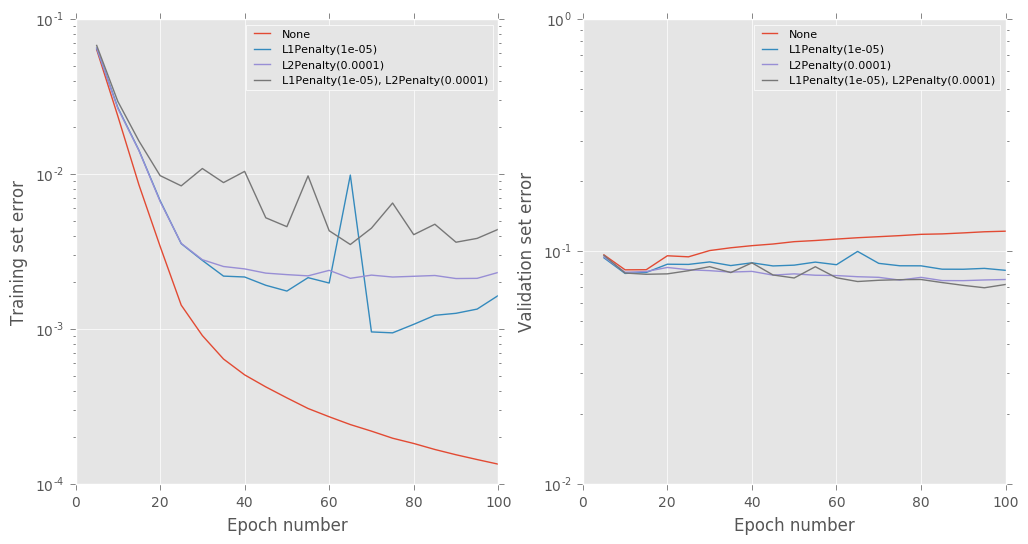

In [154]:
run_info_base = run_info_2.items()[0]
run_info_L1 = run_info_2.items()[1]
run_info_L2 = run_info_2.items()[3]
run_info_L12 = run_info.items()[2]
x = run_info_base + run_info_L1 + run_info_L2 +run_info_L12

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for i in range(0,4):
    weight_penalty = x[2*i]
    run = x[2*i+1]
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
    i += 1
ax1.legend(loc='best',prop={'size':8})
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best',prop={'size':8})
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig("L1_L2_with_all.pdf")
# run_info_total.update(run_info_base) 
# stats_base, keys_base, run_time_base = run_base
# stats_all = OrderedDi

# ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#              stats[1:, keys['error(train)']], label=str(weight_penalty))
# ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#              stats[1:, keys['error(valid)']], label=str(weight_penalty))

## Part 2: Data Augmentation

Rotated data implemented in lab 5

In [6]:
from scipy.ndimage.interpolation import rotate
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

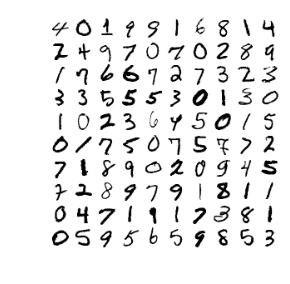

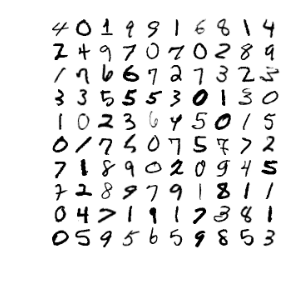

In [7]:
def show_batch_of_images(img_batch, fig_size=(3, 3)):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    # calculate no. columns per grid row to give square grid
    grid_size = int(batch_size**0.5)
    # intialise empty array to tile image grid into
    tiled = np.empty((im_height * grid_size, 
                      im_width * batch_size // grid_size))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % grid_size, i // grid_size
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()
_ = show_batch_of_images(inputs.reshape((-1, 28, 28)))
transformed_inputs = random_rotation(inputs, rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)))

In [53]:
from mlp.data_providers import AugmentedMNISTDataProvider

aug_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation)

In [54]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data.reset()
valid_data.reset()
aug_train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data, valid_data, data_monitors)

aug_stats, aug_keys, aug_run_time = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 0:
  error(train)=2.30e+00, acc(train)=9.99e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.43s to complete
  error(train)=1.45e-01, acc(train)=9.57e-01, error(valid)=1.23e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 10: 2.47s to complete
  error(train)=8.53e-02, acc(train)=9.74e-01, error(valid)=8.48e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 2.48s to complete
  error(train)=6.26e-02, acc(train)=9.81e-01, error(valid)=7.69e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 2.44s to complete
  error(train)=5.26e-02, acc(train)=9.85e-01, error(valid)=7.79e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 2.50s to complete
  error(train)=4.33e-02, acc(train)=9.88e-01, error(valid)=7.29e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 2.51s to complete
  error(train)=3.72e-02, acc(train)=9.89e-01, error(valid)=7.23e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 2.46s to complet

Zoomed data

In [46]:
from scipy.ndimage.interpolation import zoom
import random
def random_zoom(inputs, rng):
    """Randomly zoom a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images zoomed by a random factor ranged from -0.8 to 1.2. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i, j in enumerate(indices):
        zoom_factor = random.uniform(0.8, 1.2)
        zoomed_size = int(np.round(zoom_factor*28)) 
        middle = int(np.round(zoom_factor*28)/2)
#         half = zoomed_size/2
        if zoom_factor >= 1.0:
            new_ims[j] = zoom(orig_ims[j], zoom=zoom_factor, order=1)[middle-14:middle+14,middle-14:middle+14]
        else:
            b = 14 - middle
            new_ims[j][b:b+zoomed_size,b:b+zoomed_size] = zoom(orig_ims[j],zoom=zoom_factor,order=1)
           
    return new_ims.reshape((-1, 784))

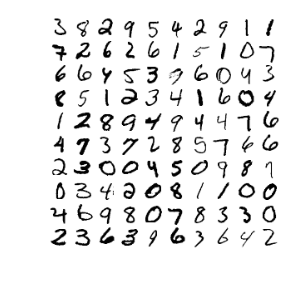

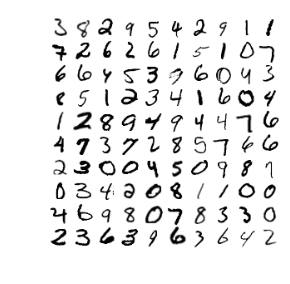

In [47]:
test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()
org_img, org_axis = show_batch_of_images(inputs.reshape((-1, 28, 28)))
fig.savefig("zoom_org.pdf")
transformed_inputs = random_zoom(inputs, rng)
zoom_img, zoom_axis = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)))
fig.savefig("zoom_img.pdf")

In [20]:
from mlp.data_providers import AugmentedMNISTDataProvider

aug_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoom)

In [21]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data.reset()
valid_data.reset()
aug_train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data, valid_data, data_monitors)

zoom_stats, zoom_keys, zoom_run_time = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 0:
  error(train)=2.30e+00, acc(train)=9.77e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.24s to complete
  error(train)=1.35e-01, acc(train)=9.60e-01, error(valid)=1.26e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 10: 2.24s to complete
  error(train)=7.37e-02, acc(train)=9.79e-01, error(valid)=8.81e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 15: 2.13s to complete
  error(train)=5.12e-02, acc(train)=9.84e-01, error(valid)=8.05e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 2.17s to complete
  error(train)=3.53e-02, acc(train)=9.90e-01, error(valid)=7.46e-02, acc(valid)=9.80e-01, params_penalty=0.00e+00
Epoch 25: 2.17s to complete
  error(train)=2.92e-02, acc(train)=9.92e-01, error(valid)=7.81e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 2.16s to complete
  error(train)=2.74e-02, acc(train)=9.92e-01, error(valid)=7.90e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 2.15s to complet

Elastic deformation

In [54]:
import numpy
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_deformation(inputs, rng, alpha = 34, sigma=4):
    """Randomly zoom a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    shape = orig_ims[0].shape

    for i, j in enumerate(indices):
        dx = gaussian_filter((rng.rand(*shape) * 2 -1), sigma, mode='constant', cval=0) * alpha
        dy = gaussian_filter((rng.rand(*shape) * 2 -1), sigma, mode='constant', cval=0) * alpha
        x, y = numpy.meshgrid(numpy.arange(shape[1]), numpy.arange(shape[0]))
        i = numpy.reshape(y+dy, (-1, 1)), numpy.reshape(x+dx, (-1, 1))
        new_ims[j] = map_coordinates(orig_ims[j], i, order=1).reshape(shape)
    return new_ims.reshape((-1, 784))

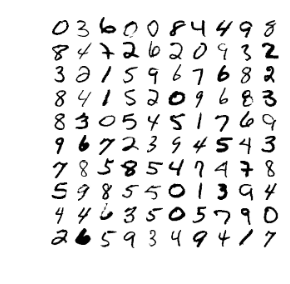

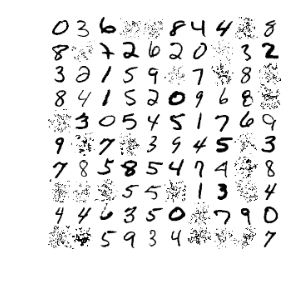

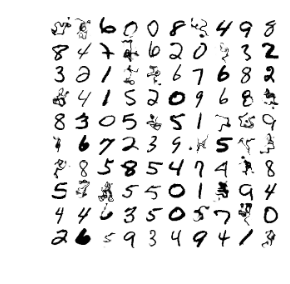

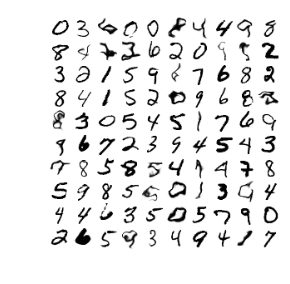

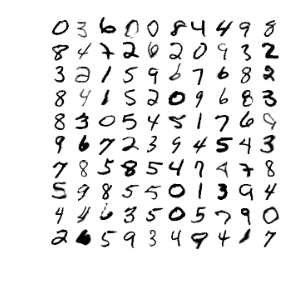

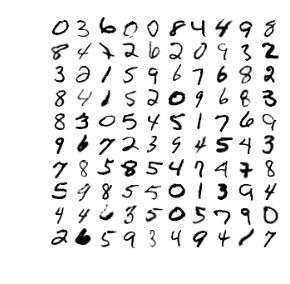

In [56]:
seed = 24102016 
rng = np.random.RandomState(seed)
test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()
org_fig,org_axis = show_batch_of_images(inputs.reshape((-1, 28, 28)))
org_fig.savefig("ela_org.pdf")
alpha = 34
sigmas = [1,2,3,4,5]
for sigma in sigmas:
    transformed_inputs = elastic_deformation(inputs, rng, alpha, sigma)
    ela_fig, ela_axis = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)))
    fig_name = "ela_sig_{0}.pdf".format(sigma)
    ela_fig.savefig(fig_name)

In [32]:
from mlp.data_providers import AugmentedMNISTDataProvider

aug_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=elastic_deformation)

In [33]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

rng.seed(seed)
aug_train_data.reset()
valid_data.reset()
aug_train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, aug_train_data, valid_data, data_monitors)
elastic_stats, elastic_keys, elastic_run_time = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 0:
  error(train)=2.30e+00, acc(train)=9.88e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 6.39s to complete
  error(train)=2.09e-01, acc(train)=9.36e-01, error(valid)=1.07e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 10: 6.59s to complete
  error(train)=1.52e-01, acc(train)=9.56e-01, error(valid)=8.04e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 15: 6.40s to complete
  error(train)=1.28e-01, acc(train)=9.61e-01, error(valid)=6.77e-02, acc(valid)=9.80e-01, params_penalty=0.00e+00
Epoch 20: 6.67s to complete
  error(train)=1.10e-01, acc(train)=9.66e-01, error(valid)=6.39e-02, acc(valid)=9.81e-01, params_penalty=0.00e+00
Epoch 25: 6.43s to complete
  error(train)=9.45e-02, acc(train)=9.71e-01, error(valid)=5.84e-02, acc(valid)=9.84e-01, params_penalty=0.00e+00
Epoch 30: 6.69s to complete
  error(train)=8.74e-02, acc(train)=9.74e-01, error(valid)=5.43e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 35: 6.59s to complet

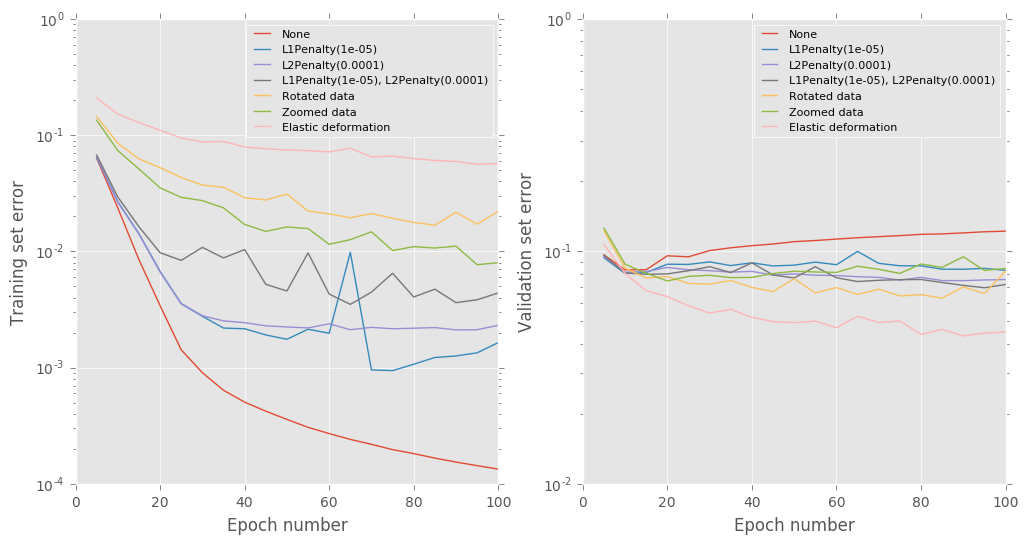

In [59]:
run_info_base = run_info_2.items()[0]
run_info_L1 = run_info_2.items()[1]
run_info_L2 = run_info_2.items()[3]
run_info_L12 = run_info.items()[2]
x = run_info_base + run_info_L1 + run_info_L2 +run_info_L12

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for i in range(0,4):
    weight_penalty = x[2*i]
    run = x[2*i+1]
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
    i += 1
ax1.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_stats[1:, aug_keys['error(train)']], label='Rotated data')
ax2.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_stats[1:, aug_keys['error(valid)']], label='Rotated data')

ax1.plot(np.arange(1, zoom_stats.shape[0]) * stats_interval, 
         zoom_stats[1:, zoom_keys['error(train)']], label='Zoomed data')
ax2.plot(np.arange(1, zoom_stats.shape[0]) * stats_interval, 
         zoom_stats[1:, zoom_keys['error(valid)']], label='Zoomed data')

ax1.plot(np.arange(1, elastic_stats.shape[0]) * stats_interval, 
         elastic_stats[1:, elastic_keys['error(train)']], label='Elastic deformation')
ax2.plot(np.arange(1, elastic_stats.shape[0]) * stats_interval, 
         elastic_stats[1:, elastic_keys['error(valid)']], label='Elastic deformation')
ax1.legend(loc='best',prop={'size':8})
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='best',prop={'size':8})
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('Error_aug.pdf')

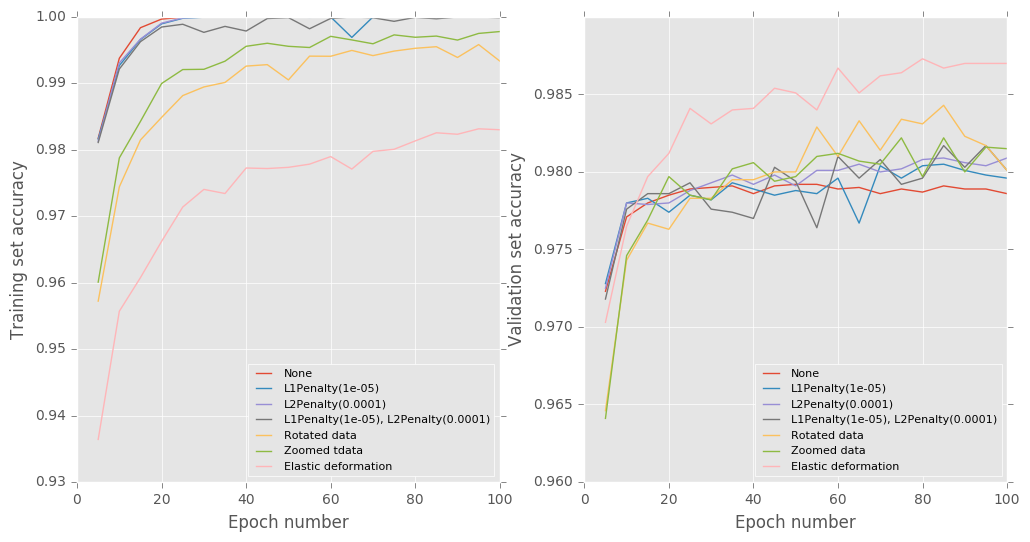

In [60]:
run_info_base = run_info_2.items()[0]
run_info_L1 = run_info_2.items()[1]
run_info_L2 = run_info_2.items()[3]
run_info_L12 = run_info.items()[2]
x = run_info_base + run_info_L1 + run_info_L2 +run_info_L12

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for i in range(0,4):
    weight_penalty = x[2*i]
    run = x[2*i+1]
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']], label=str(weight_penalty))
    i += 1
ax1.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_stats[1:, aug_keys['acc(train)']], label='Rotated data')
ax2.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_stats[1:, aug_keys['acc(valid)']], label='Rotated data')

ax1.plot(np.arange(1, zoom_stats.shape[0]) * stats_interval, 
         zoom_stats[1:, zoom_keys['acc(train)']], label='Zoomed tdata')
ax2.plot(np.arange(1, zoom_stats.shape[0]) * stats_interval, 
         zoom_stats[1:, zoom_keys['acc(valid)']], label='Zoomed data')
ax1.plot(np.arange(1, elastic_stats.shape[0]) * stats_interval, 
         elastic_stats[1:, elastic_keys['acc(train)']], label='Elastic deformation')
ax2.plot(np.arange(1, elastic_stats.shape[0]) * stats_interval, 
         elastic_stats[1:, elastic_keys['acc(valid)']], label='Elastic deformation')
ax1.legend(loc='best',prop={'size':8})
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')
ax2.legend(loc='best',prop={'size':8})
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')
fig.savefig('acc_aug.pdf')